# GRU Model  
Predicting Droughts Using Weather & Soil Data in the US


## Instructions  
This notebook is designed to run on Google Colab. It requires at least 25 GB of system RAM and 1.5 GB of GPU RAM, so a T4 GPU with high-RAM runtime is recommended.

You do not need to manually install any datasets. Just simply run the cell codes.

The instruction to load the model parameters can be found at the end of this notebook.

# Import

In [1]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import kagglehub
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Data preprocessing

In [2]:
path = kagglehub.dataset_download("cdminix/us-drought-meteorological-data")

# Load data
soil_df = pd.read_csv(os.path.join(path, "soil_data.csv"))
train_df = pd.read_csv(os.path.join(path, "train_timeseries/train_timeseries.csv"))
val_df = pd.read_csv(os.path.join(path, "validation_timeseries/validation_timeseries.csv"))
test_df = pd.read_csv(os.path.join(path, "test_timeseries/test_timeseries.csv"))

# Define feature lists
weather_features = ['PRECTOT', 'PS', 'QV2M', 'T2M', 'T2MDEW', 'T2MWET', 'T2M_MAX', 'T2M_MIN',
                    'T2M_RANGE', 'TS', 'WS10M', 'WS10M_MAX', 'WS10M_MIN', 'WS10M_RANGE',
                    'WS50M', 'WS50M_MAX', 'WS50M_MIN', 'WS50M_RANGE']
soil_features = ['lat', 'lon', 'elevation', 'slope1', 'slope2', 'slope3', 'slope4', 'slope5',
                 'slope6', 'slope7', 'slope8', 'aspectN', 'aspectE', 'aspectS', 'aspectW',
                 'aspectUnknown', 'WAT_LAND', 'NVG_LAND', 'URB_LAND', 'GRS_LAND', 'FOR_LAND',
                 'CULTRF_LAND', 'CULTIR_LAND', 'CULT_LAND', 'SQ1', 'SQ2', 'SQ3', 'SQ4', 'SQ5',
                 'SQ6', 'SQ7']

#Merge soil data and add seasonal features
for df in [train_df, val_df, test_df]:
    df['date'] = pd.to_datetime(df['date'])
    df.sort_values(['fips', 'date'], inplace=True)
    day_of_year = df['date'].dt.dayofyear
    df['season_sin'] = np.sin(2 * np.pi * (day_of_year - 1) / 365)
    df['season_cos'] = np.cos(2 * np.pi * (day_of_year - 1) / 365)
train_df = train_df.merge(soil_df, on='fips', how='left')
val_df = val_df.merge(soil_df, on='fips', how='left')
test_df = test_df.merge(soil_df, on='fips', how='left')

# Feature scaling
train_features = train_df[weather_features + soil_features].values
feature_mean = np.nanmean(train_features, axis=0)
feature_std = np.nanstd(train_features, axis=0)
feature_std = np.where(feature_std == 0, 1.0, feature_std)
for df in [train_df, val_df, test_df]:
    df[weather_features + soil_features] = (
        df[weather_features + soil_features].values - feature_mean
    ) / feature_std

dynamic_features = weather_features + ['season_sin', 'season_cos']
static_features = soil_features
target = 'score'

In [3]:
class DroughtDataset(Dataset):
    def __init__(self, df, dynamic_features, static_features, target, seq_length=30):
        self.dynamic_features = dynamic_features
        self.static_features = static_features
        self.target = target
        self.seq_length = seq_length
        self.data = {}
        self.indices = []
        df = df.sort_values(['fips', 'date']).copy()
        for fips, fips_df in df.groupby('fips'):
            X_dynamic = fips_df[dynamic_features].values.astype(np.float32)
            X_static = fips_df[static_features].iloc[0].values.astype(np.float32)
            y = fips_df[target].values.astype(np.float32)
            self.data[fips] = {'X_dynamic': X_dynamic, 'X_static': X_static, 'y': y}
            for i in range(len(fips_df) - seq_length):
                if not np.isnan(y[i + seq_length]):
                    self.indices.append((fips, i))

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        fips, start_idx = self.indices[idx]
        X_dynamic = self.data[fips]['X_dynamic'][start_idx:start_idx + self.seq_length]
        X_static = self.data[fips]['X_static']
        y = self.data[fips]['y'][start_idx + self.seq_length]
        return (torch.from_numpy(X_dynamic), torch.from_numpy(X_static), torch.tensor(y, dtype=torch.float32))

# Model Version 2

The GRU model modified by adding another dropout layer on top of the GRU internal layer dropout and a layer norm was also implemented

In [ ]:
class GRUDroughtModel(nn.Module):
    def __init__(self, dynamic_input_size, static_input_size, hidden_size, num_layers, dropout_rate):
        super(GRUDroughtModel, self).__init__()

        self.gru = nn.GRU(
            input_size=dynamic_input_size + static_input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout_rate if num_layers > 1 else 0.0
        )

        #LayerNorm for the GRU output
        self.norm = nn.LayerNorm(hidden_size)
        #Dropout before the final FC layer
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x_dynamic, x_static):
        batch_size, seq_length, _ = x_dynamic.size()

        x_static_repeated = x_static.unsqueeze(1).repeat(1, seq_length, 1)
        x = torch.cat([x_dynamic, x_static_repeated], dim=2)

        _, h_n = self.gru(x)
        out = h_n[-1]  # shape: (batch_size, hidden_size)
        #Apply LayerNorm and Dropout before the final prediction
        out = self.norm(out)
        out = self.dropout(out)
        out = self.fc(out)

        return out.squeeze(-1)  # shape: (batch_size,)

# Training Model Version 2

In [7]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, save_path, device, patience=3, scheduler=None):
    train_losses, val_losses, train_maes, val_maes = [], [], [], []
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        #Training loop
        model.train()
        train_loss, train_mae, train_samples = 0.0, 0.0, 0
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for X_dynamic, X_static, y_batch in train_bar:
            X_dynamic, X_static, y_batch = X_dynamic.to(device), X_static.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_dynamic, X_static)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_dynamic.size(0)
            mae = torch.mean(torch.abs(outputs - y_batch))
            train_mae += mae.item() * X_dynamic.size(0)
            train_samples += X_dynamic.size(0)
            train_bar.set_postfix({"Loss": loss.item(), "MAE": mae.item()})

        train_loss /= train_samples
        train_mae /= train_samples
        train_losses.append(train_loss)
        train_maes.append(train_mae)

        #Validation loop
        model.eval()
        val_loss, val_mae, val_samples = 0.0, 0.0, 0
        val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
        with torch.no_grad():
            for X_dynamic, X_static, y_batch in val_bar:
                X_dynamic, X_static, y_batch = X_dynamic.to(device), X_static.to(device), y_batch.to(device)
                outputs = model(X_dynamic, X_static)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item() * X_dynamic.size(0)
                mae = torch.mean(torch.abs(outputs - y_batch))
                val_mae += mae.item() * X_dynamic.size(0)
                val_samples += X_dynamic.size(0)
                val_bar.set_postfix({"Loss": loss.item(), "MAE": mae.item()})

        val_loss /= val_samples
        val_mae /= val_samples
        val_losses.append(val_loss)
        val_maes.append(val_mae)

        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {train_loss:.4f}, Train MAE: {train_mae:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val MAE: {val_mae:.4f}")

        #Checkpointing and Early Stopping
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss
        }
        torch.save(checkpoint, f"{save_path}_epoch{epoch+1}.pt")
        print(f"Checkpoint saved at {save_path}_epoch{epoch+1}.pt")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(checkpoint, save_path)
            print(f"Best model updated at {save_path}")
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break

        if scheduler:
            scheduler.step(val_loss)

    #Plot Losses
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
    plt.plot(range(1, len(val_losses)+1), val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    #Plot MAEs
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_maes)+1), train_maes, label='Train MAE')
    plt.plot(range(1, len(val_maes)+1), val_maes, label='Val MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.title('Training and Validation MAE')
    plt.legend()
    plt.grid(True)
    plt.show()

    return model, train_losses, val_losses, train_maes, val_maes


In [ ]:
hidden_size = 64
num_layers = 2
num_epochs = 10
batch_size = 2048
seq_length = 90
patience = 2

In [ ]:
train_dataset = DroughtDataset(train_df, dynamic_features, static_features, target, seq_length)
val_dataset = DroughtDataset(val_df, dynamic_features, static_features, target, seq_length)
test_dataset = DroughtDataset(test_df, dynamic_features, static_features, target, seq_length)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



🟢 Training with dropout = 0.0


Epoch 1/10 [Val]: 100%|██████████| 139/139 [00:06<00:00, 22.82it/s, Loss=1.39, MAE=1]


Epoch 1/10, Train Loss: 0.7021, Train MAE: 0.5764, Val Loss: 0.5298, Val MAE: 0.4852
Checkpoint saved at best_model_dropout0.0.pt_epoch1.pt
Best model updated at best_model_dropout0.0.pt


Epoch 2/10 [Val]: 100%|██████████| 139/139 [00:05<00:00, 27.61it/s, Loss=1.88, MAE=1.19]


Epoch 2/10, Train Loss: 0.4795, Train MAE: 0.4569, Val Loss: 0.5599, Val MAE: 0.4786
Checkpoint saved at best_model_dropout0.0.pt_epoch2.pt


Epoch 3/10 [Val]: 100%|██████████| 139/139 [00:05<00:00, 23.19it/s, Loss=1.91, MAE=1.08]


Epoch 3/10, Train Loss: 0.3847, Train MAE: 0.4039, Val Loss: 0.5722, Val MAE: 0.4733
Checkpoint saved at best_model_dropout0.0.pt_epoch3.pt
Early stopping triggered after 3 epochs


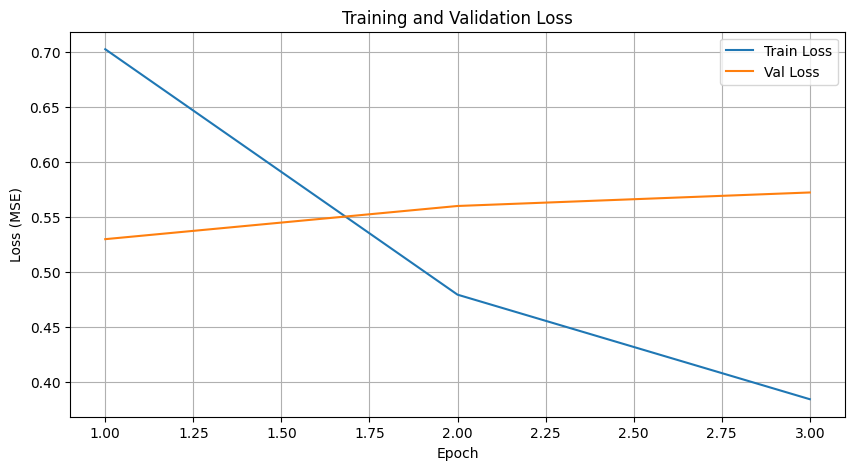

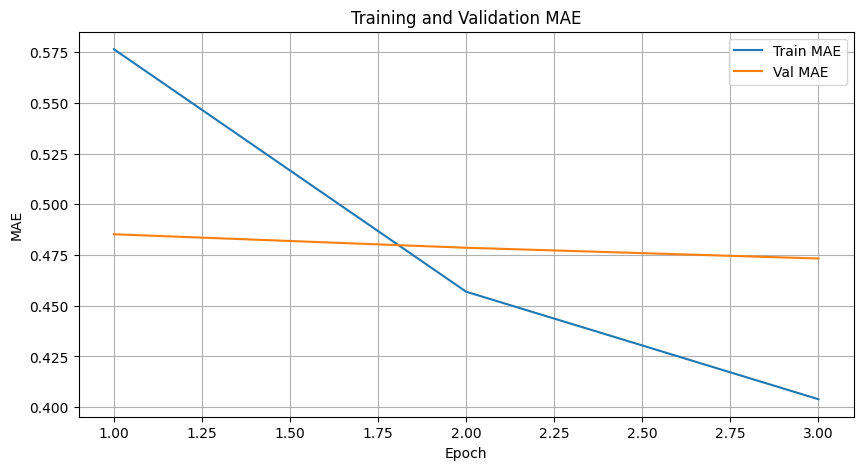

🔍 Evaluating model with dropout=0.0 on test set...


Test Evaluation: 100%|██████████| 140/140 [00:06<00:00, 22.24it/s]


✅ Dropout 0.0 — Test Loss: 0.4795, Test MAE: 0.4147

🟢 Training with dropout = 0.2


Epoch 1/10 [Val]: 100%|██████████| 139/139 [00:06<00:00, 21.44it/s, Loss=1.83, MAE=1.2]


Epoch 1/10, Train Loss: 0.7212, Train MAE: 0.5859, Val Loss: 0.5146, Val MAE: 0.4547
Checkpoint saved at best_model_dropout0.2.pt_epoch1.pt
Best model updated at best_model_dropout0.2.pt


Epoch 2/10 [Val]: 100%|██████████| 139/139 [00:06<00:00, 22.76it/s, Loss=2.01, MAE=1.25]


Epoch 2/10, Train Loss: 0.5033, Train MAE: 0.4710, Val Loss: 0.5394, Val MAE: 0.4598
Checkpoint saved at best_model_dropout0.2.pt_epoch2.pt


Epoch 3/10 [Val]: 100%|██████████| 139/139 [00:04<00:00, 30.52it/s, Loss=2.72, MAE=1.36]


Epoch 3/10, Train Loss: 0.4219, Train MAE: 0.4260, Val Loss: 0.5700, Val MAE: 0.4610
Checkpoint saved at best_model_dropout0.2.pt_epoch3.pt
Early stopping triggered after 3 epochs


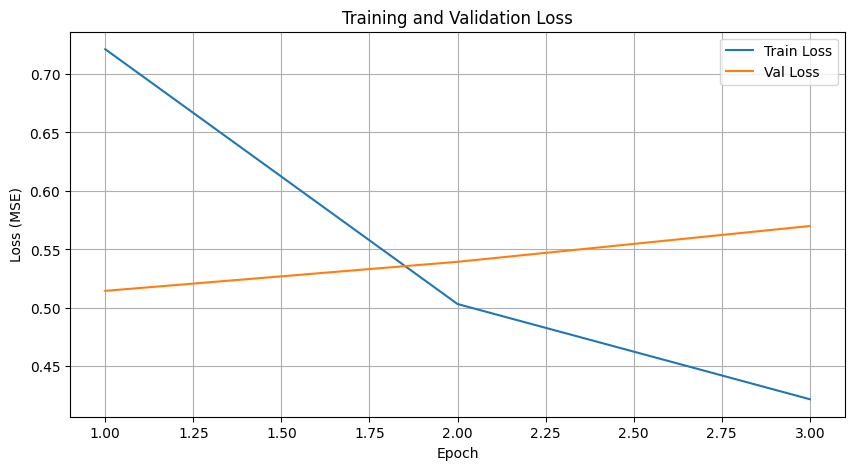

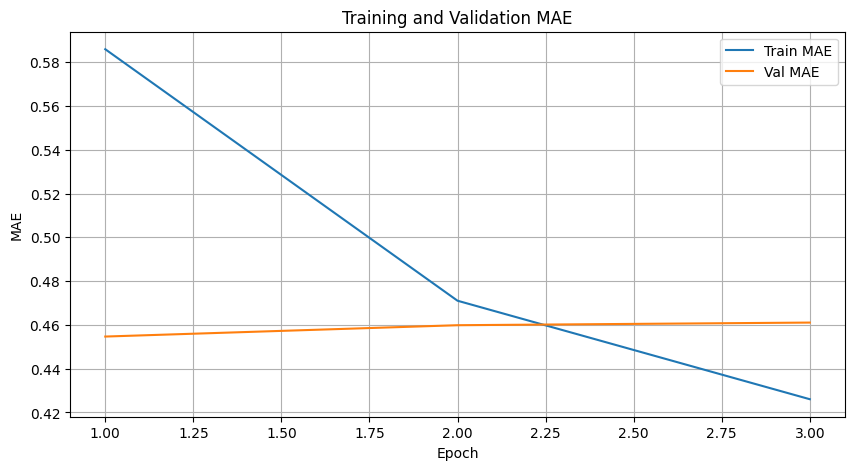

🔍 Evaluating model with dropout=0.2 on test set...


Test Evaluation: 100%|██████████| 140/140 [00:05<00:00, 25.81it/s]


✅ Dropout 0.2 — Test Loss: 0.4635, Test MAE: 0.3981

🟢 Training with dropout = 0.3


Epoch 1/10 [Val]: 100%|██████████| 139/139 [00:06<00:00, 22.71it/s, Loss=1.14, MAE=0.924]


Epoch 1/10, Train Loss: 0.7453, Train MAE: 0.5961, Val Loss: 0.4700, Val MAE: 0.4291
Checkpoint saved at best_model_dropout0.3.pt_epoch1.pt
Best model updated at best_model_dropout0.3.pt


Epoch 2/10 [Val]: 100%|██████████| 139/139 [00:05<00:00, 24.10it/s, Loss=1.55, MAE=1.12]


Epoch 2/10, Train Loss: 0.5406, Train MAE: 0.4906, Val Loss: 0.5227, Val MAE: 0.4470
Checkpoint saved at best_model_dropout0.3.pt_epoch2.pt


Epoch 3/10 [Val]: 100%|██████████| 139/139 [00:06<00:00, 22.19it/s, Loss=2.18, MAE=1.28]


Epoch 3/10, Train Loss: 0.4521, Train MAE: 0.4437, Val Loss: 0.5319, Val MAE: 0.4563
Checkpoint saved at best_model_dropout0.3.pt_epoch3.pt
Early stopping triggered after 3 epochs


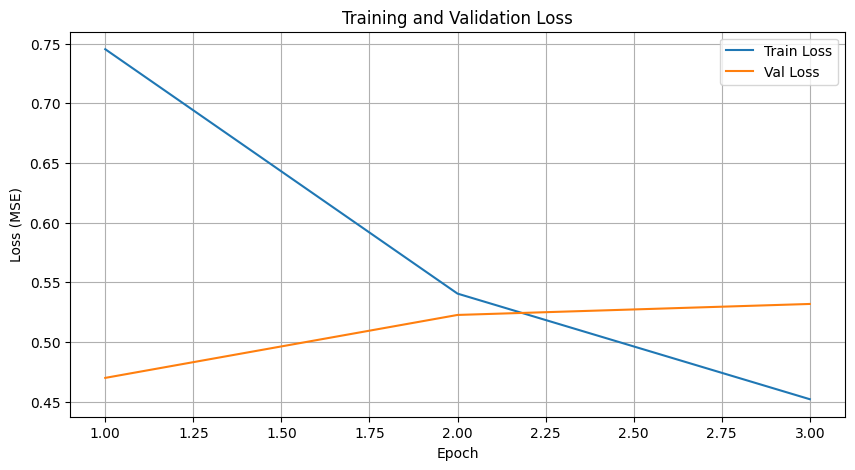

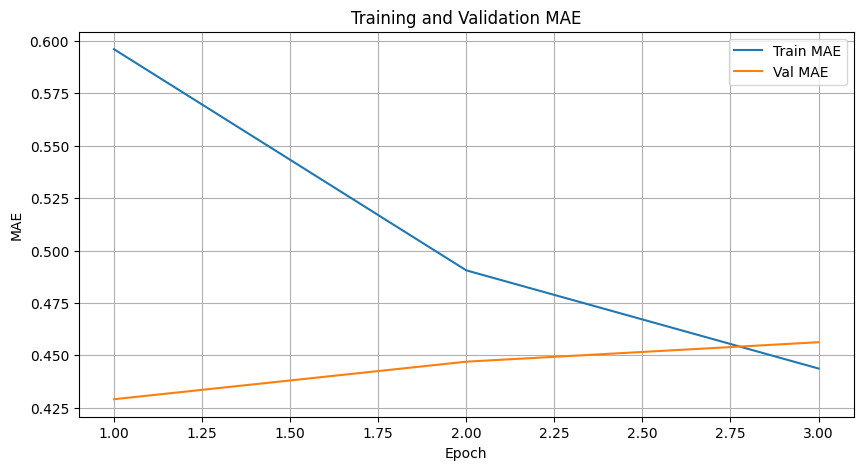

🔍 Evaluating model with dropout=0.3 on test set...


Test Evaluation: 100%|██████████| 140/140 [00:05<00:00, 25.27it/s]


✅ Dropout 0.3 — Test Loss: 0.5039, Test MAE: 0.4154

🟢 Training with dropout = 0.5


Epoch 1/10 [Val]: 100%|██████████| 139/139 [00:05<00:00, 23.82it/s, Loss=1.53, MAE=1.13]


Epoch 1/10, Train Loss: 0.7727, Train MAE: 0.6086, Val Loss: 0.5216, Val MAE: 0.4764
Checkpoint saved at best_model_dropout0.5.pt_epoch1.pt
Best model updated at best_model_dropout0.5.pt


Epoch 2/10 [Val]: 100%|██████████| 139/139 [00:05<00:00, 24.19it/s, Loss=1.79, MAE=1.2]


Epoch 2/10, Train Loss: 0.5469, Train MAE: 0.4980, Val Loss: 0.5289, Val MAE: 0.4638
Checkpoint saved at best_model_dropout0.5.pt_epoch2.pt


Epoch 3/10 [Val]: 100%|██████████| 139/139 [00:06<00:00, 22.01it/s, Loss=1.52, MAE=1.04]


Epoch 3/10, Train Loss: 0.4668, Train MAE: 0.4583, Val Loss: 0.4971, Val MAE: 0.4443
Checkpoint saved at best_model_dropout0.5.pt_epoch3.pt
Best model updated at best_model_dropout0.5.pt


Epoch 4/10 [Val]: 100%|██████████| 139/139 [00:05<00:00, 25.69it/s, Loss=1.16, MAE=0.869]


Epoch 4/10, Train Loss: 0.4166, Train MAE: 0.4333, Val Loss: 0.4966, Val MAE: 0.4646
Checkpoint saved at best_model_dropout0.5.pt_epoch4.pt
Best model updated at best_model_dropout0.5.pt


Epoch 5/10 [Val]: 100%|██████████| 139/139 [00:06<00:00, 21.53it/s, Loss=2.63, MAE=1.38]


Epoch 5/10, Train Loss: 0.3794, Train MAE: 0.4143, Val Loss: 0.5388, Val MAE: 0.4574
Checkpoint saved at best_model_dropout0.5.pt_epoch5.pt


Epoch 6/10 [Val]: 100%|██████████| 139/139 [00:06<00:00, 21.14it/s, Loss=2, MAE=1.12]


Epoch 6/10, Train Loss: 0.3508, Train MAE: 0.3987, Val Loss: 0.5096, Val MAE: 0.4437
Checkpoint saved at best_model_dropout0.5.pt_epoch6.pt
Early stopping triggered after 6 epochs


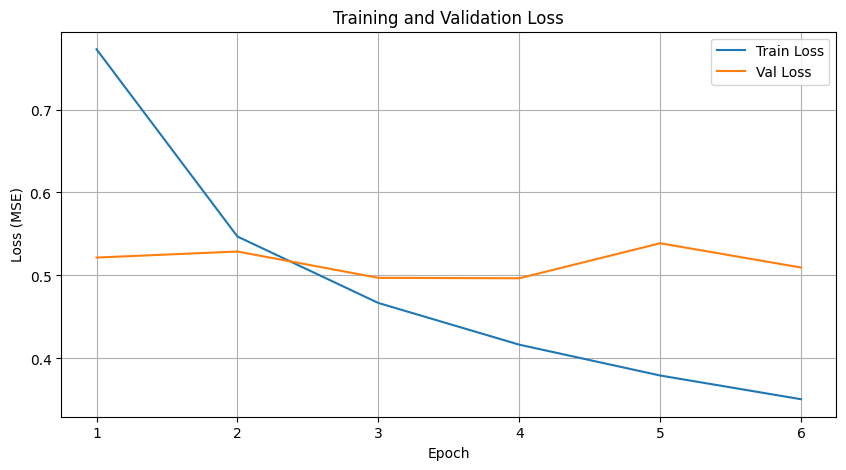

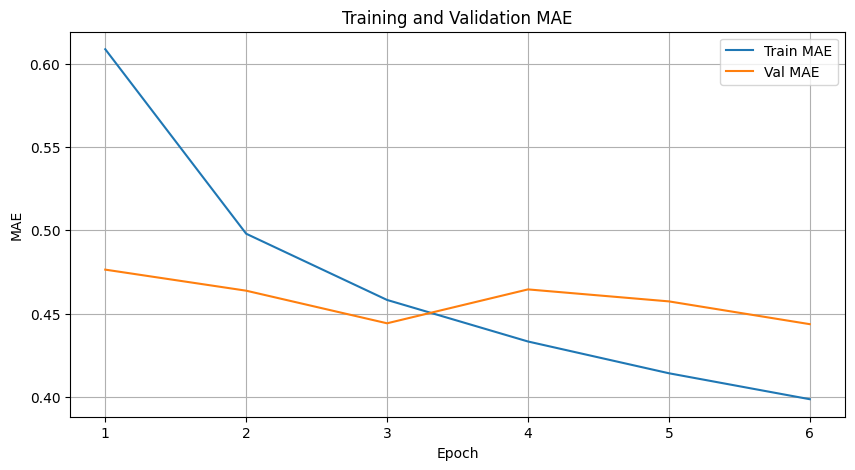

🔍 Evaluating model with dropout=0.5 on test set...


Test Evaluation: 100%|██████████| 140/140 [00:06<00:00, 22.05it/s]

✅ Dropout 0.5 — Test Loss: 0.4868, Test MAE: 0.4133


In [ ]:
dropout_values = [0.0, 0.2, 0.3, 0.5]
results = {}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.MSELoss()

for dropout_rate in dropout_values:
    print(f"\n🟢 Training with dropout = {dropout_rate}")

    # Initialize model
    model = GRUDroughtModel(
        dynamic_input_size=len(dynamic_features),
        static_input_size=len(static_features),
        hidden_size=hidden_size,
        num_layers=num_layers,
        dropout_rate=dropout_rate
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5, verbose=True)

    # Train the model
    model, train_losses, val_losses, train_maes, val_maes = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=num_epochs,
        save_path=f"best_model_dropout{dropout_rate}.pt",
        device=device,
        patience=patience,
        scheduler=scheduler
    )

    # Store training curves
    results[dropout_rate] = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_maes': train_maes,
        'val_maes': val_maes,
    }

    # Evaluate on test set
    print(f"🔍 Evaluating model with dropout={dropout_rate} on test set...")
    model.eval()
    test_loss, test_mae, test_samples = 0.0, 0.0, 0
    test_predictions = []

    with torch.no_grad():
        for X_dynamic, X_static, y_batch in tqdm(test_loader, desc="Test Evaluation"):
            X_dynamic, X_static, y_batch = X_dynamic.to(device), X_static.to(device), y_batch.to(device)
            outputs = model(X_dynamic, X_static)
            valid_mask = ~torch.isnan(y_batch)
            if valid_mask.sum() > 0:
                valid_outputs = outputs[valid_mask]
                valid_targets = y_batch[valid_mask]
                loss = criterion(valid_outputs, valid_targets)
                test_loss += loss.item() * valid_mask.sum().item()
                mae = torch.mean(torch.abs(valid_outputs - valid_targets))
                test_mae += mae.item() * valid_mask.sum().item()
                test_samples += valid_mask.sum().item()
            test_predictions.extend(outputs.cpu().numpy())

    if test_samples > 0:
        test_loss /= test_samples
        test_mae /= test_samples
        print(f"✅ Dropout {dropout_rate} — Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}")
    else:
        print("⚠️ No valid test targets (all NaN)")

    # Save test predictions for this model
    np.save(f'test_predictions_dropout{dropout_rate}.npy', np.array(test_predictions))


# Model Version 3

This model gives the best result out of all. This model implemented by using a layer norm and a dropout layer and no internal dropout in the GRU internal layer.

In [4]:
class GRUDroughtModel(nn.Module):
    def __init__(self, dynamic_input_size, static_input_size, hidden_size, num_layers, dropout_rate):
        super(GRUDroughtModel, self).__init__()

        self.gru = nn.GRU(
            input_size=dynamic_input_size + static_input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
        )

        #LayerNorm for the GRU output
        self.norm = nn.LayerNorm(hidden_size)
        #Dropout before the final FC layer
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x_dynamic, x_static):
        batch_size, seq_length, _ = x_dynamic.size()

        x_static_repeated = x_static.unsqueeze(1).repeat(1, seq_length, 1)
        x = torch.cat([x_dynamic, x_static_repeated], dim=2)

        _, h_n = self.gru(x)
        out = h_n[-1]  # shape: (batch_size, hidden_size)
        #Apply LayerNorm and Dropout before the final prediction
        out = self.norm(out)
        out = self.dropout(out)
        out = self.fc(out)

        return out.squeeze(-1)  # shape: (batch_size,)

# Training model version 3

In [5]:
hidden_size = 64
num_layers = 2
num_epochs = 10
batch_size = 2048
seq_length = 90
patience = 2

In [6]:
train_dataset = DroughtDataset(train_df, dynamic_features, static_features, target, seq_length)
val_dataset = DroughtDataset(val_df, dynamic_features, static_features, target, seq_length)
test_dataset = DroughtDataset(test_df, dynamic_features, static_features, target, seq_length)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


🟢 Training with dropout = 0.0


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/10 [Val]: 100%|██████████| 139/139 [00:04<00:00, 30.54it/s, Loss=1.2, MAE=0.984]


Epoch 1/10, Train Loss: 0.7013, Train MAE: 0.5738, Val Loss: 0.4719, Val MAE: 0.4485
Checkpoint saved at best_model_dropout0.0.pt_epoch1.pt
Best model updated at best_model_dropout0.0.pt


Epoch 2/10 [Val]: 100%|██████████| 139/139 [00:04<00:00, 27.97it/s, Loss=1.98, MAE=1.23]


Epoch 2/10, Train Loss: 0.4889, Train MAE: 0.4611, Val Loss: 0.5990, Val MAE: 0.4828
Checkpoint saved at best_model_dropout0.0.pt_epoch2.pt


Epoch 3/10 [Val]: 100%|██████████| 139/139 [00:04<00:00, 31.56it/s, Loss=2.62, MAE=1.45]


Epoch 3/10, Train Loss: 0.3934, Train MAE: 0.4084, Val Loss: 0.5338, Val MAE: 0.4618
Checkpoint saved at best_model_dropout0.0.pt_epoch3.pt
Early stopping triggered after 3 epochs


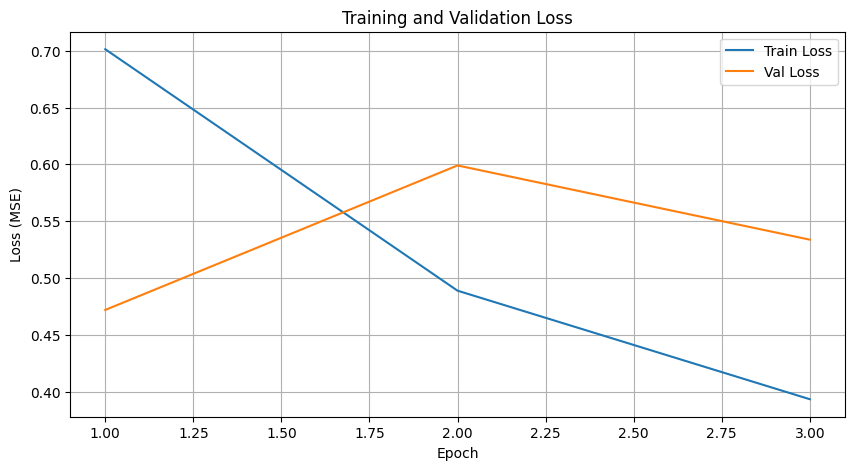

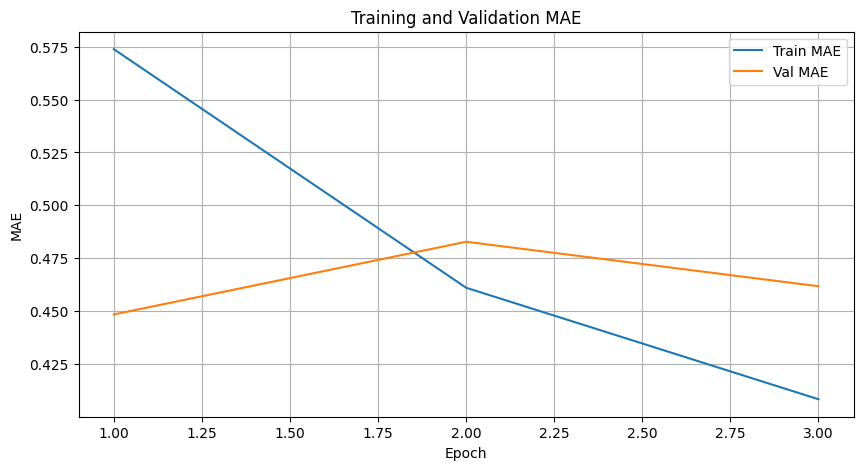

🔍 Evaluating model with dropout=0.0 on test set...


Test Evaluation: 100%|██████████| 140/140 [00:04<00:00, 30.23it/s]


✅ Dropout 0.0 — Test Loss: 0.4973, Test MAE: 0.4228

🟢 Training with dropout = 0.2


Epoch 1/10 [Val]: 100%|██████████| 139/139 [00:04<00:00, 29.13it/s, Loss=1.46, MAE=1.01]


Epoch 1/10, Train Loss: 0.7178, Train MAE: 0.5837, Val Loss: 0.5299, Val MAE: 0.4664
Checkpoint saved at best_model_dropout0.2.pt_epoch1.pt
Best model updated at best_model_dropout0.2.pt


Epoch 2/10 [Val]: 100%|██████████| 139/139 [00:04<00:00, 28.52it/s, Loss=1.53, MAE=1.05]


Epoch 2/10, Train Loss: 0.5049, Train MAE: 0.4711, Val Loss: 0.6147, Val MAE: 0.4913
Checkpoint saved at best_model_dropout0.2.pt_epoch2.pt


Epoch 3/10 [Val]: 100%|██████████| 139/139 [00:04<00:00, 28.76it/s, Loss=1.53, MAE=1.04]


Epoch 3/10, Train Loss: 0.4130, Train MAE: 0.4218, Val Loss: 0.5412, Val MAE: 0.4468
Checkpoint saved at best_model_dropout0.2.pt_epoch3.pt
Early stopping triggered after 3 epochs


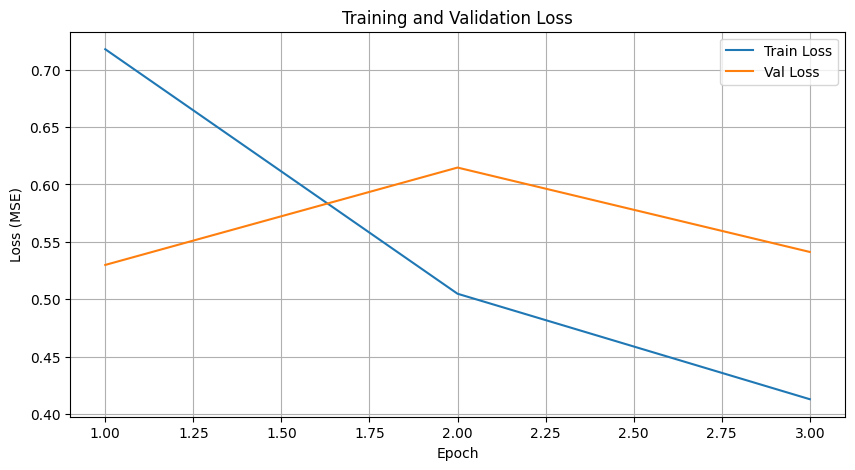

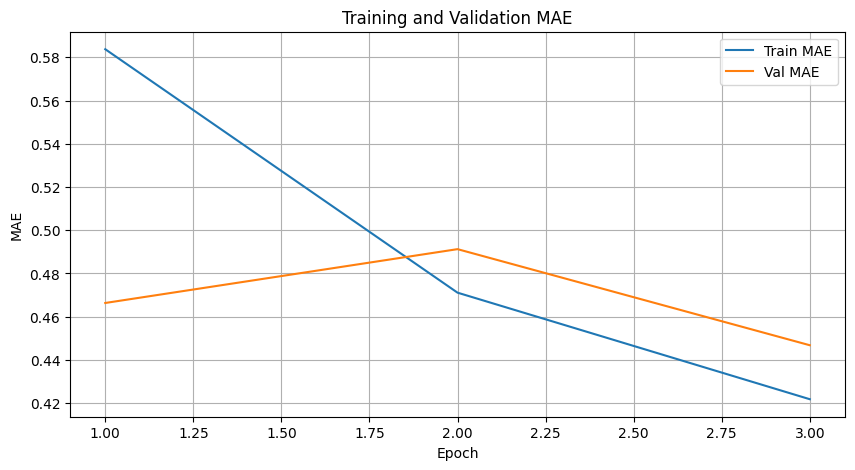

🔍 Evaluating model with dropout=0.2 on test set...


Test Evaluation: 100%|██████████| 140/140 [00:04<00:00, 29.90it/s]


✅ Dropout 0.2 — Test Loss: 0.4348, Test MAE: 0.3794

🟢 Training with dropout = 0.3


Epoch 1/10 [Val]: 100%|██████████| 139/139 [00:04<00:00, 30.42it/s, Loss=1.7, MAE=1.16]


Epoch 1/10, Train Loss: 0.7412, Train MAE: 0.5943, Val Loss: 0.5229, Val MAE: 0.4684
Checkpoint saved at best_model_dropout0.3.pt_epoch1.pt
Best model updated at best_model_dropout0.3.pt


Epoch 2/10 [Val]: 100%|██████████| 139/139 [00:04<00:00, 29.76it/s, Loss=1.94, MAE=1.24]


Epoch 2/10, Train Loss: 0.5255, Train MAE: 0.4843, Val Loss: 0.4970, Val MAE: 0.4431
Checkpoint saved at best_model_dropout0.3.pt_epoch2.pt
Best model updated at best_model_dropout0.3.pt


Epoch 3/10 [Val]: 100%|██████████| 139/139 [00:04<00:00, 29.18it/s, Loss=2.11, MAE=1.26]


Epoch 3/10, Train Loss: 0.4319, Train MAE: 0.4347, Val Loss: 0.5189, Val MAE: 0.4419
Checkpoint saved at best_model_dropout0.3.pt_epoch3.pt


Epoch 4/10 [Val]: 100%|██████████| 139/139 [00:05<00:00, 27.06it/s, Loss=1.55, MAE=1.09]


Epoch 4/10, Train Loss: 0.3760, Train MAE: 0.4046, Val Loss: 0.5546, Val MAE: 0.4501
Checkpoint saved at best_model_dropout0.3.pt_epoch4.pt
Early stopping triggered after 4 epochs


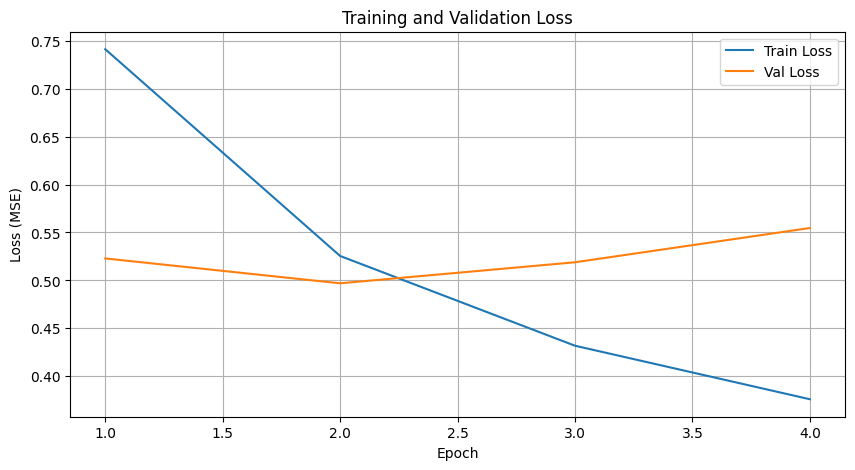

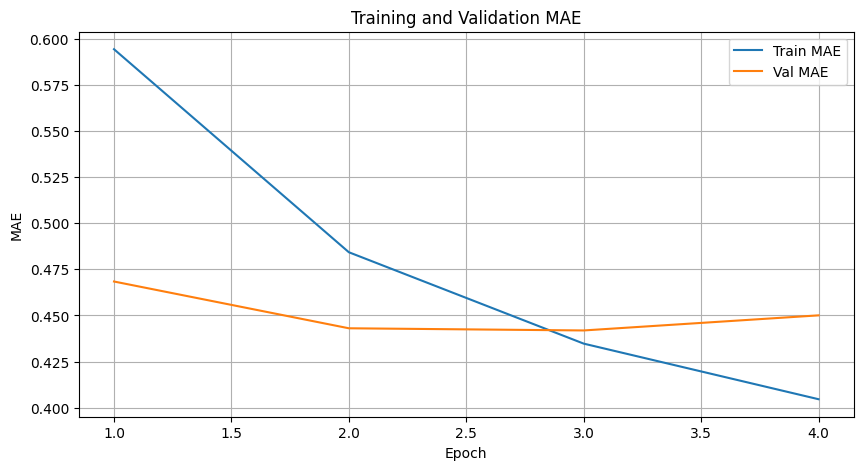

🔍 Evaluating model with dropout=0.3 on test set...


Test Evaluation: 100%|██████████| 140/140 [00:04<00:00, 30.93it/s]


✅ Dropout 0.3 — Test Loss: 0.5099, Test MAE: 0.4152

🟢 Training with dropout = 0.4


Epoch 1/10 [Val]: 100%|██████████| 139/139 [00:04<00:00, 28.64it/s, Loss=1.47, MAE=1.05]


Epoch 1/10, Train Loss: 0.7483, Train MAE: 0.5982, Val Loss: 0.4642, Val MAE: 0.4439
Checkpoint saved at best_model_dropout0.4.pt_epoch1.pt
Best model updated at best_model_dropout0.4.pt


Epoch 2/10 [Val]: 100%|██████████| 139/139 [00:05<00:00, 27.09it/s, Loss=1.87, MAE=1.16]


Epoch 2/10, Train Loss: 0.5392, Train MAE: 0.4910, Val Loss: 0.4747, Val MAE: 0.4283
Checkpoint saved at best_model_dropout0.4.pt_epoch2.pt


Epoch 3/10 [Val]: 100%|██████████| 139/139 [00:04<00:00, 29.38it/s, Loss=1.73, MAE=1.11]


Epoch 3/10, Train Loss: 0.4532, Train MAE: 0.4462, Val Loss: 0.5317, Val MAE: 0.4447
Checkpoint saved at best_model_dropout0.4.pt_epoch3.pt
Early stopping triggered after 3 epochs


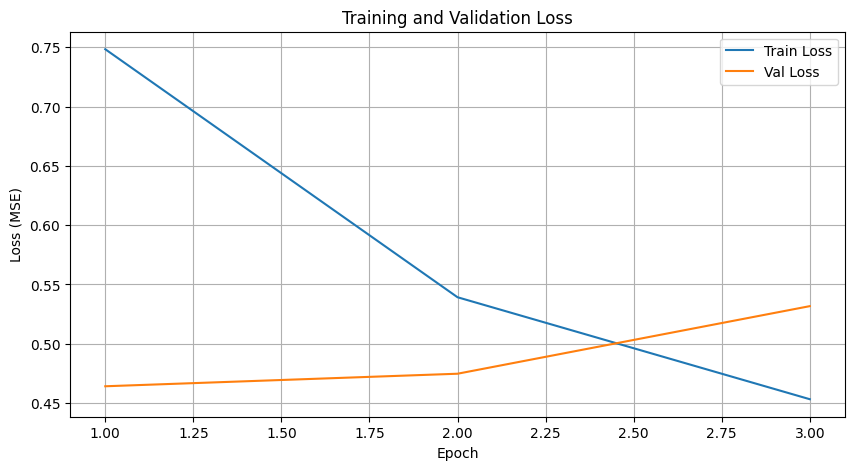

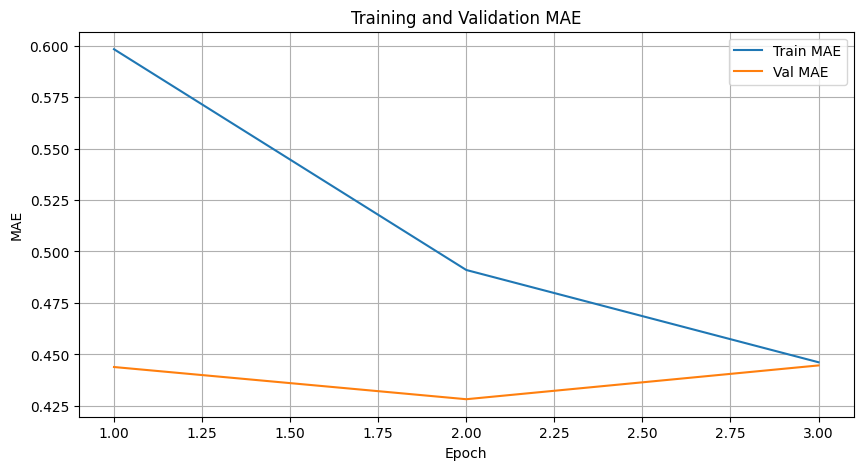

🔍 Evaluating model with dropout=0.4 on test set...


Test Evaluation: 100%|██████████| 140/140 [00:04<00:00, 29.19it/s]


✅ Dropout 0.4 — Test Loss: 0.4803, Test MAE: 0.3991

🟢 Training with dropout = 0.5


Epoch 1/10 [Val]: 100%|██████████| 139/139 [00:05<00:00, 27.08it/s, Loss=0.867, MAE=0.828]


Epoch 1/10, Train Loss: 0.7585, Train MAE: 0.6019, Val Loss: 0.4629, Val MAE: 0.4366
Checkpoint saved at best_model_dropout0.5.pt_epoch1.pt
Best model updated at best_model_dropout0.5.pt


Epoch 2/10 [Val]: 100%|██████████| 139/139 [00:05<00:00, 27.40it/s, Loss=1.04, MAE=0.883]


Epoch 2/10, Train Loss: 0.5432, Train MAE: 0.4964, Val Loss: 0.5705, Val MAE: 0.4789
Checkpoint saved at best_model_dropout0.5.pt_epoch2.pt


Epoch 3/10 [Val]: 100%|██████████| 139/139 [00:04<00:00, 29.90it/s, Loss=2.22, MAE=1.28]


Epoch 3/10, Train Loss: 0.4535, Train MAE: 0.4523, Val Loss: 0.6269, Val MAE: 0.4995
Checkpoint saved at best_model_dropout0.5.pt_epoch3.pt
Early stopping triggered after 3 epochs


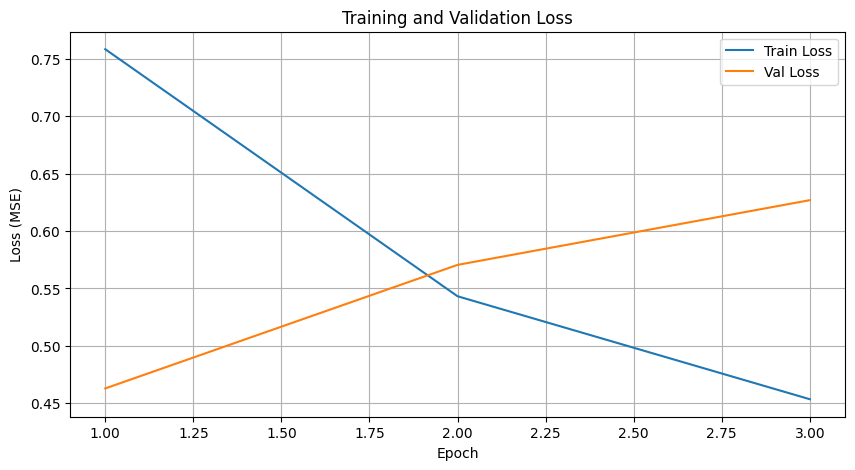

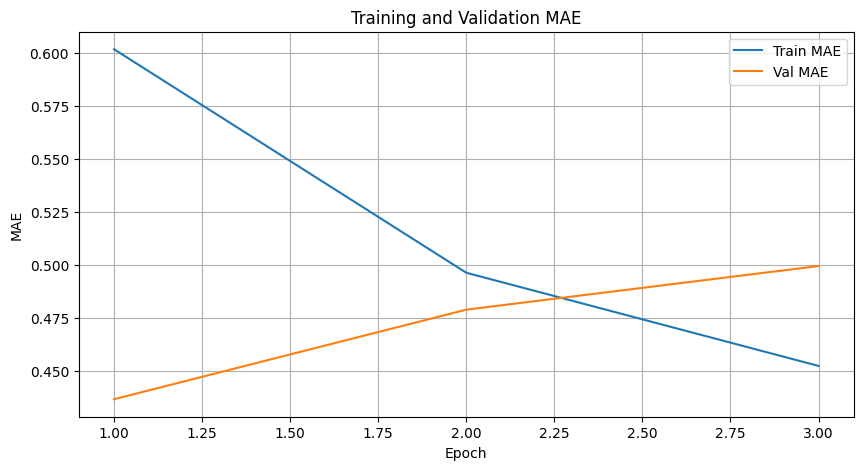

🔍 Evaluating model with dropout=0.5 on test set...


Test Evaluation: 100%|██████████| 140/140 [00:04<00:00, 29.89it/s]

✅ Dropout 0.5 — Test Loss: 0.4837, Test MAE: 0.4194


In [8]:
# if you intend to just load a model parameter without doing the full training, you can skip this cell
dropout_values = [0.0, 0.2, 0.3, 0.4, 0.5]
results = {}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.MSELoss()

for dropout_rate in dropout_values:
    print(f"\n🟢 Training with dropout = {dropout_rate}")

    # Initialize model
    model = GRUDroughtModel(
        dynamic_input_size=len(dynamic_features),
        static_input_size=len(static_features),
        hidden_size=hidden_size,
        num_layers=num_layers,
        dropout_rate=dropout_rate
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5, verbose=True)

    # Train the model
    model, train_losses, val_losses, train_maes, val_maes = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=num_epochs,
        save_path=f"best_model_dropout{dropout_rate}.pt",
        device=device,
        patience=patience,
        scheduler=scheduler
    )

    # Store training curves
    results[dropout_rate] = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_maes': train_maes,
        'val_maes': val_maes,
    }

    # Evaluate on test set
    print(f"🔍 Evaluating model with dropout={dropout_rate} on test set...")
    model.eval()
    test_loss, test_mae, test_samples = 0.0, 0.0, 0
    test_predictions = []

    with torch.no_grad():
        for X_dynamic, X_static, y_batch in tqdm(test_loader, desc="Test Evaluation"):
            X_dynamic, X_static, y_batch = X_dynamic.to(device), X_static.to(device), y_batch.to(device)
            outputs = model(X_dynamic, X_static)
            valid_mask = ~torch.isnan(y_batch)
            if valid_mask.sum() > 0:
                valid_outputs = outputs[valid_mask]
                valid_targets = y_batch[valid_mask]
                loss = criterion(valid_outputs, valid_targets)
                test_loss += loss.item() * valid_mask.sum().item()
                mae = torch.mean(torch.abs(valid_outputs - valid_targets))
                test_mae += mae.item() * valid_mask.sum().item()
                test_samples += valid_mask.sum().item()
            test_predictions.extend(outputs.cpu().numpy())

    if test_samples > 0:
        test_loss /= test_samples
        test_mae /= test_samples
        print(f"✅ Dropout {dropout_rate} — Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}")
    else:
        print("⚠️ No valid test targets (all NaN)")

    # Save test predictions for this model
    np.save(f'test_predictions_dropout{dropout_rate}.npy', np.array(test_predictions))


For running the best result of the model with the model parameter without run the full training, you can just run this cell code without running the training cells above.

In [ ]:
save_path = 'best_model_dropout0.2.pt'

In [ ]:
# Run this if you intend to just load the model parameter
# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GRUDroughtModel(
    dynamic_input_size=len(dynamic_features),
    static_input_size=len(static_features),
    hidden_size=hidden_size,
    num_layers=num_layers,
    dropout_rate=dropout_rate
).to(device)


# Evaluation
checkpoint_path = save_path
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.to(device)
model.eval()
test_loss, test_mae, test_samples = 0.0, 0.0, 0
test_predictions = []
with torch.no_grad():
    for X_dynamic, X_static, y_batch in tqdm(test_loader, desc="Test Evaluation"):
        X_dynamic, X_static, y_batch = X_dynamic.to(device), X_static.to(device), y_batch.to(device)
        outputs = model(X_dynamic, X_static)
        valid_mask = ~torch.isnan(y_batch)
        if valid_mask.sum() > 0:
            valid_outputs = outputs[valid_mask]
            valid_targets = y_batch[valid_mask]
            loss = criterion(valid_outputs, valid_targets)
            test_loss += loss.item() * valid_mask.sum().item()
            mae = torch.mean(torch.abs(valid_outputs - valid_targets))
            test_mae += mae.item() * valid_mask.sum().item()
            test_samples += valid_mask.sum().item()
        test_predictions.extend(outputs.cpu().numpy())

# Print the final test results
if test_samples > 0:
    test_loss /= test_samples
    test_mae /= test_samples
    print(f"Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}")
else:
    print("No valid test targets (all NaN), predictions collected.")

# Save the predictions
np.save('test_predictions.npy', np.array(test_predictions))